In [0]:
#start tika server. The Tika Server is the Parser
#java -jar "path\to\tika-server-1.22.jar"


1. Reading Texts from Documents and Data Cleaning


In [0]:
#import necessary modules
import tika
tika.initVM()
from tika import parser
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [0]:
#define a parameter for tika parsers. This declaration solves the status 422 server error
headers = {'X-Tika-PDFextractInlineImages': 'true', "X-Tika-OCRLanguage": "eng"} 

In [0]:
#import project data
arch_df = pd.read_csv(r"parsed-arch_data-training-data-2.csv", encoding = "ISO-8859-1")

In [0]:
#parse text from scanned files
def ocr_pdf(file):
    images = convert_from_path(file)
    ocr_list = [pytesseract.image_to_string(x) for x in images]
    ocr = ''
    return ocr.join(ocr_list)

In [0]:
#Run Tika Parser on Texts
def return_parsed(paths):
    try:
        return parser.from_file(paths, headers=headers)
    except:
        return 'path error'

In [0]:
#Extract Text from files
def return_texts(parsed, paths):
    if 'content' in parsed and parsed['content'] is not None:
        return parsed['content'] #extract 'content' from parsed texts
    else:
        try:
            return ocr_pdf(paths) #if no 'content' from tika parser, try OCRing the document
        except:
            return "no content"   

In [0]:
#Remove trailing and leading whitespace
def remove_whitespace(text):
    return text.strip()

In [0]:
#Parse Files
parsed = arch_df.apply(lambda row: return_parsed(row['Path']), axis = 1).compute()
arch_df['Parsed'] = parsed 

In [0]:
#Extract Text
texts =  arch_df.apply(lambda row: return_texts(row['Parsed'], row['Path']), axis = 1).compute()
arch_df['Texts'] = texts

In [0]:
#Drop rows with no text content
no_content = arch_df[arch_df['Texts'] == 'no content'].index
arch_df.drop(no_content, inplace=True)
isnan = arch_df[arch_df['Arch_Data'].isna() == True].index
arch_df.drop(isnan, inplace=True)

In [0]:
#Remove Whitespace from Arch Data Values
Arch_Data = arch_df.apply(lambda row: remove_whitespace(row['Arch_Data']), axis = 1)
arch_df['Arch_Data'] = Arch_Data

In [0]:
#Save DataFrame as csv file
arch_df.to_csv(r"\\esri-shelf\ESRIENVIROHUB\TaggerBot\parsed-arch_data-training-data-2.csv")

In [0]:
arch_df.shape

(962, 8)

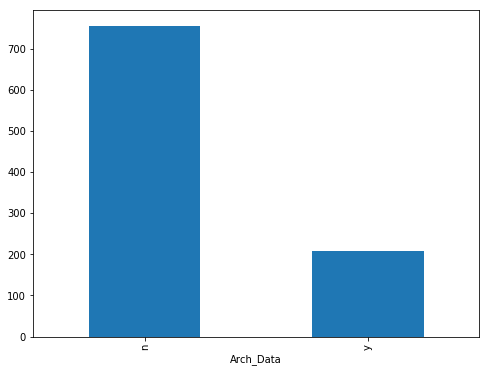

In [0]:
#Plot of Document Samples Grouped by Arch Data
fig = plt.figure(figsize=(8,6))
arch_df.groupby('Arch_Data').Texts.count().plot.bar(ylim=0)
plt.show()


# 2. Model Training and Testing


In [0]:
#Create Vectorizer Object
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

In [0]:
#create the ML labels by factorizing
y, mappings =arch_df.Arch_Data.factorize()

In [0]:
#Define X value
X = arch_df.Texts

In [0]:
#Split data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

In [0]:
#Vectorize X_train and X_test
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

In [0]:
# Create the list of alphas: alphas
alphas = np.arange(0, 1, .1)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(X_train, y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(y_test, pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.0
Score:  0.9689119170984456

Alpha:  0.1
Score:  0.9533678756476683

Alpha:  0.2
Score:  0.9637305699481865

Alpha:  0.30000000000000004
Score:  0.9637305699481865

Alpha:  0.4
Score:  0.9533678756476683

Alpha:  0.5
Score:  0.9430051813471503

Alpha:  0.6000000000000001
Score:  0.9378238341968912

Alpha:  0.7000000000000001
Score:  0.927461139896373

Alpha:  0.8
Score:  0.9119170984455959

Alpha:  0.9
Score:  0.9015544041450777



In [0]:
#Build, train and test classifier
clf = MultinomialNB(alpha=0.0)
clf.fit(X_train, y_train)
accuracy = clf.score(X_test, y_test)
print(accuracy)

MultinomialNB(alpha=0.0, class_prior=None, fit_prior=True)

In [0]:
# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)

# Generate the confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names = mappings))

[[151   0]
 [  6  36]]
              precision    recall  f1-score   support

           n       0.96      1.00      0.98       151
           y       1.00      0.86      0.92        42

    accuracy                           0.97       193
   macro avg       0.98      0.93      0.95       193
weighted avg       0.97      0.97      0.97       193



In [0]:
#Chi-squared test to see the unigrams and bigrams most correlated with arch documents
features_chi2 = chi2(X_train, y_train)
indices = np.argsort(features_chi2[0])
feature_names = np.array(tfidf.get_feature_names())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-20:])))
print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-20:])))

  . Most correlated unigrams:
. choquette
. heritage
. culture
. borden
. raad
. aoa
. archaeologist
. deposits
. flake
. precontact
. archaeology
. artifact
. subsurface
. artifacts
. aia
. hca
. lithics
. lithic
. cultural
. archaeological
  . Most correlated bigrams:
. site report07
. report file
. file archaeology
. conservation act
. surface lithics
. heritage conservation
. archaeological materials
. archaeological work
. recorded archaeological
. archaeological remains
. archaeological overview
. overview assessment
. previously recorded
. archaeological impact
. impact assessment
. archaeological potential
. archaeological site
. cultural material
. archaeological sites
. archaeology branch


In [0]:
#Re-define X using all available data
X = tfidf.fit_transform(arch_df.Texts).toarray()

In [0]:
#Re-train classifier using all available data
clf = MultinomialNB(alpha=0.0)
clf.fit(X, y)

In [0]:
#Save trained model
model_save = r"final-arch-model.sav"
pickle.dump(clf, open(model_save, 'wb'))

In [0]:
#Open saved trained model and test
loaded_model = pickle.load(open(model_save, 'rb'))
accuracy = loaded_model.score(X_test, y_test)
print(accuracy)